# <center>IMPORTS</center> 

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
data = pd.read_csv('g-research-crypto-forecasting/train.csv') 
asset_details = pd.read_csv('g-research-crypto-forecasting/asset_details.csv') 

# <center>EXPLORATORY DATA ANALYSIS</center> 

## Column Description
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	The number of cryptoasset units traded during the minute.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. 


In [3]:
data.head() 

timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2   40.0   2376.5800   2399.5000   2357.1400   
1  1514764860         0    5.0      8.5300      8.5300      8.5300   
2  1514764860         1  229.0  13835.1940  14013.8000  13666.1100   
3  1514764860         5   32.0      7.6596      7.6596      7.6567   
4  1514764860         7    5.0     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target  
0   2374.5900    19.233005   2373.116392 -0.004218  
1      8.5300    78.380000      8.530000 -0.014399  
2  13850.1760    31.550062  13827.062093 -0.014643  
3      7.6576  6626.713370      7.657713 -0.013922  
4     25.8770   121.087310     25.891363 -0.008264

In [4]:
data.shape

(24236806, 10)

#### Checking Null Rows

In [5]:
data.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [6]:
print("Total Null Target Rows = " ,data["Target"].isnull().sum())
print("Percentage of NUll rows in Training Data = {:.2f}%".format(data["Target"].isnull().sum()*100 / data.shape[0] ))

Total Null Target Rows =  750338
Percentage of NUll rows in Training Data = 3.10%


#### Removing Null Values

In [7]:
data = data.dropna()

In [8]:
data.shape

(23486465, 10)

# <center>DATA DISTRIBUTION</center> 

### Training Data Distribution among differnet Assets (Crypto Currencies)

In [9]:
asset_count= []
for i in range(14):
    count = (data["Asset_ID"]==i).sum()
    asset_count.append(count)
fig = px.bar(x = asset_details.sort_values("Asset_ID")["Asset_Name"],
             y = asset_count , 
             color = asset_count ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'} ,
        template="plotly_white")
fig.show()

#### The data is too huge to process on our systems, therefore we are going to take only last 1M records

In [10]:
df = data.tail(1000000)

In [11]:
df.shape

(1000000, 10)

In [12]:
asset_count= []
for i in range(14):
    count = (df["Asset_ID"]==i).sum()
    asset_count.append(count)
fig = px.bar(x = asset_details.sort_values("Asset_ID")["Asset_Name"],
             y = asset_count , 
             color = asset_count ,
             color_continuous_scale="Emrld") 
fig.update_xaxes(title="Assets")
fig.update_yaxes(title = "Number of Rows")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'} ,
        template="plotly_white")
fig.show()

# <center>DATA VISUALIZATION</center> 

In [13]:
asset_names_dict = {row["Asset_Name"]:row["Asset_ID"] for ind, row in asset_details.iterrows()}
asset_names = [
    'Bitcoin',
    'Ethereum',
    'Cardano',
    'Binance Coin',
    'Dogecoin',
    'Bitcoin Cash',
    'Litecoin',
    'Ethereum Classic',
    'Stellar',
    'TRON',
    'Monero',
    'EOS.IO',
    'IOTA',
    'Maker'
]
cmap = sns.color_palette()

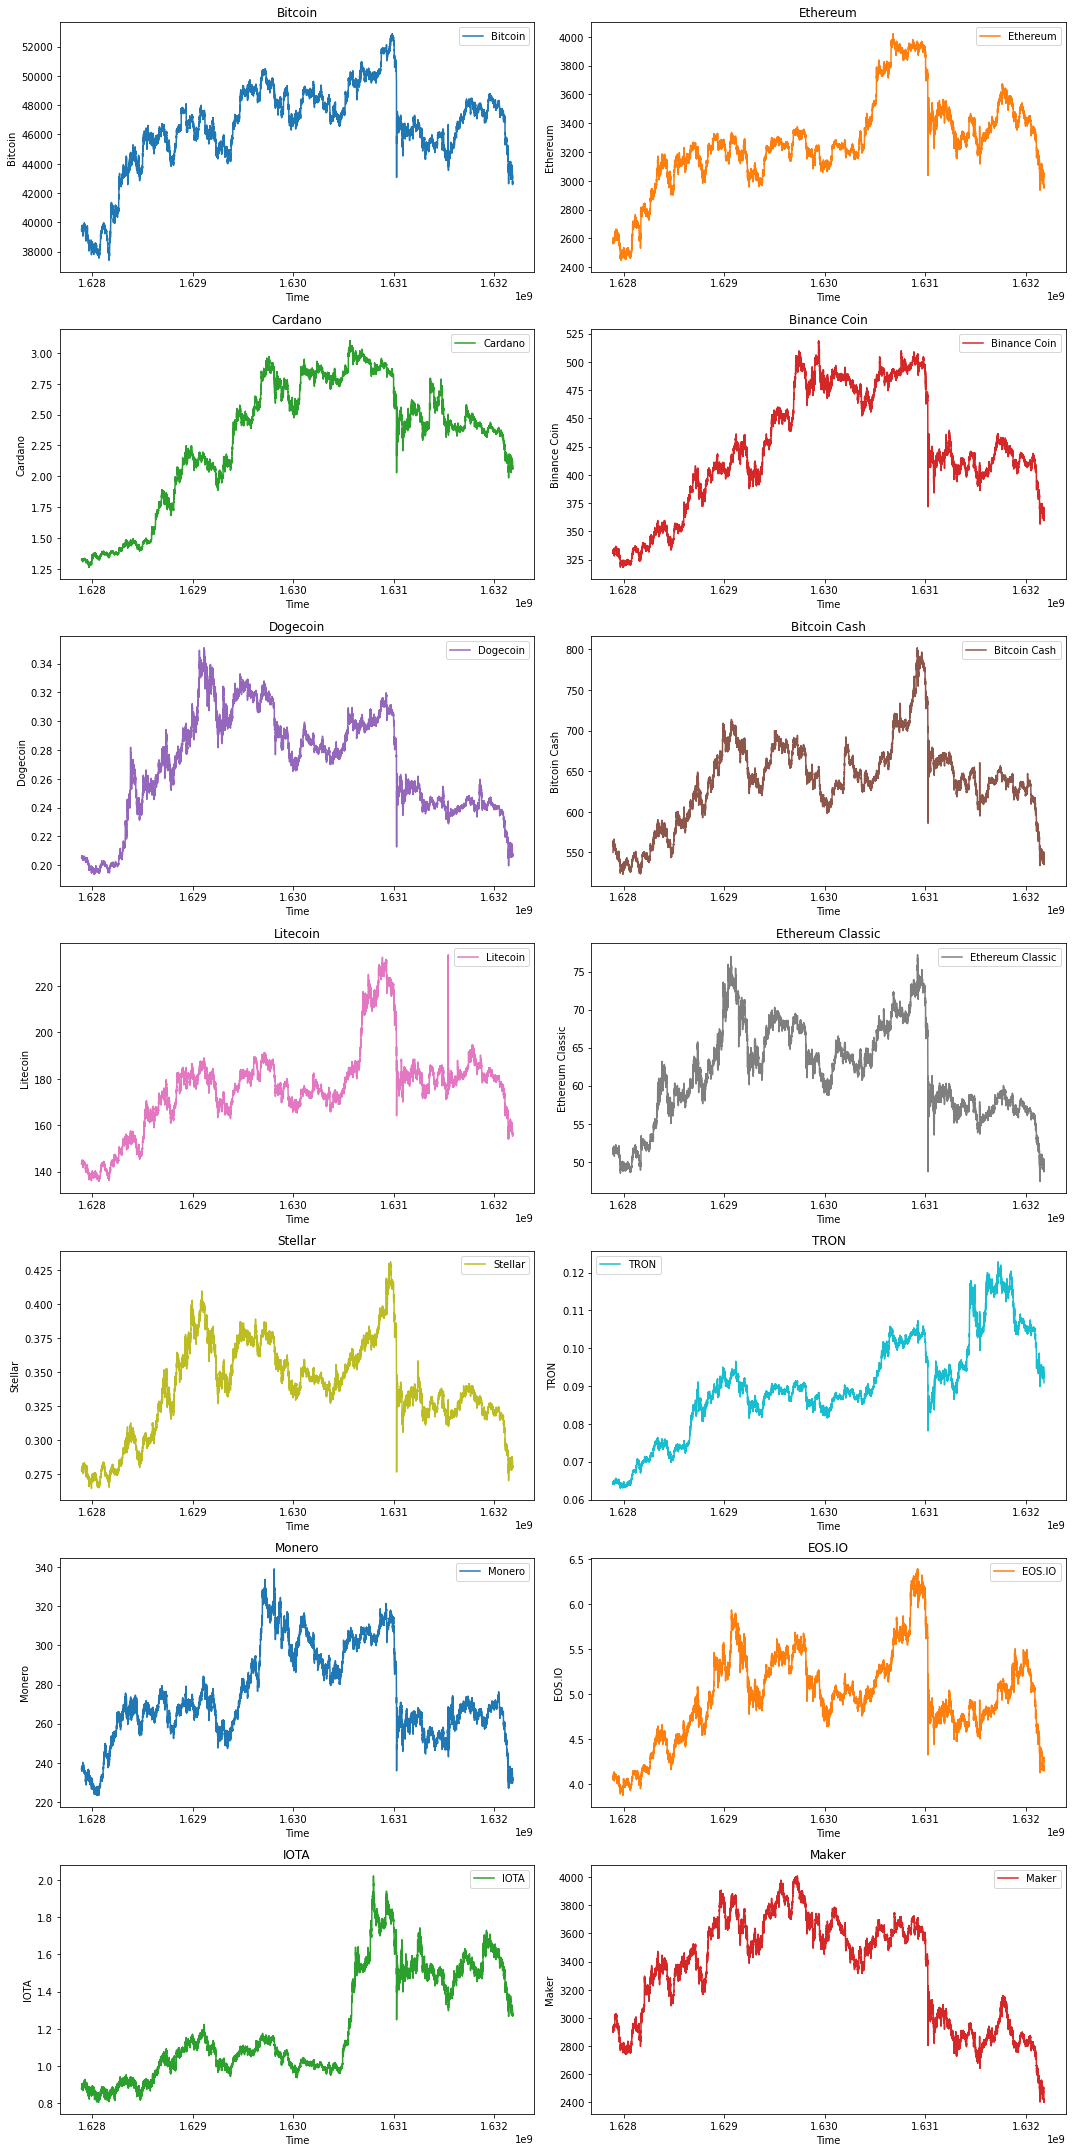

In [14]:
f = plt.figure(figsize=(15,30))

for ind, coin in enumerate(asset_names):
    coin_df = df[df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    # fill missing values 
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    ax = f.add_subplot(7,2,ind+1)
    plt.plot(coin_df['Close'], label=coin, color=cmap[ind%10])
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(coin)
    plt.title(coin)

plt.tight_layout()
plt.show()

# <center>CORRELATION</center> 


### Correlation on actual price values

Let us create a correlation plot on the actual price values of these different assets for the latest time period (from July 1, 2021).

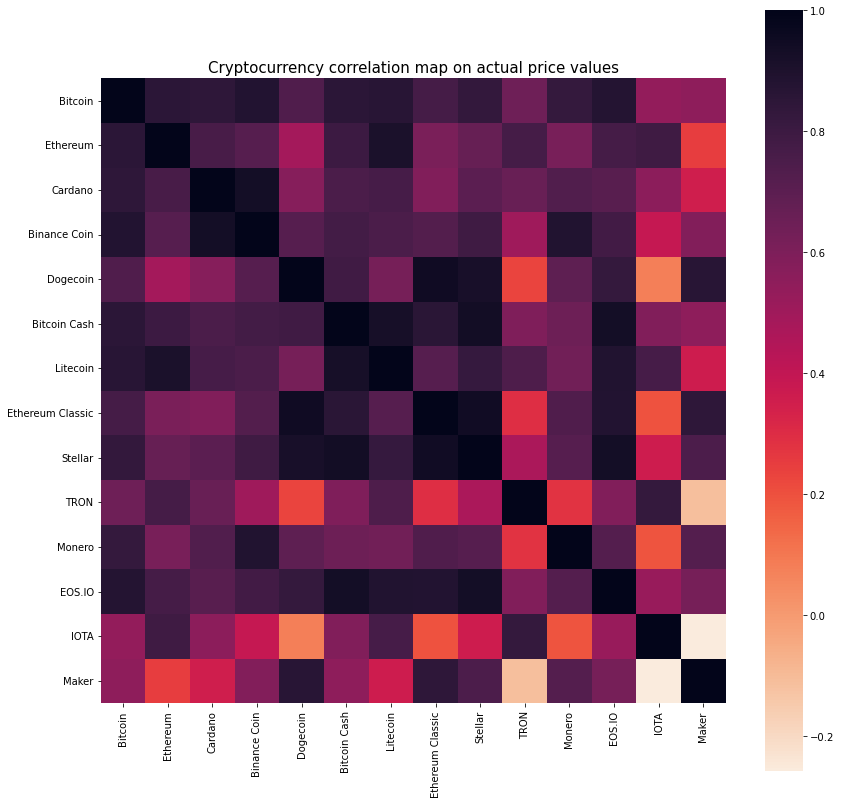

In [15]:
import time
# auxiliary function, from datetime to timestamp
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

all_assets_df = pd.DataFrame([])
for ind, coin in enumerate(asset_names):
    coin_df = df[df["Asset_ID"]==asset_names_dict[coin]].set_index("timestamp")
    coin_df = coin_df.reindex(range(coin_df.index[0],coin_df.index[-1]+60,60),method='pad')
    # fill missing values
    coin_df = coin_df.loc[totimestamp('01/07/2021'):totimestamp('21/09/2021')]
    close_values = coin_df["Close"].fillna(0)
    close_values.name = coin
    all_assets_df = all_assets_df.join(close_values, how="outer")

corrmat = all_assets_df.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corrmat, vmax=1., square=True, cmap="rocket_r")
plt.title("Cryptocurrency correlation map on actual price values", fontsize=15)
plt.show()

##  Autocorrelation and Partial Autocorrelation
* Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.
* Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags.  The terms can be interpreted the same way as a standard  linear regression, that is the contribution of a change in that particular lag while holding others constant. 


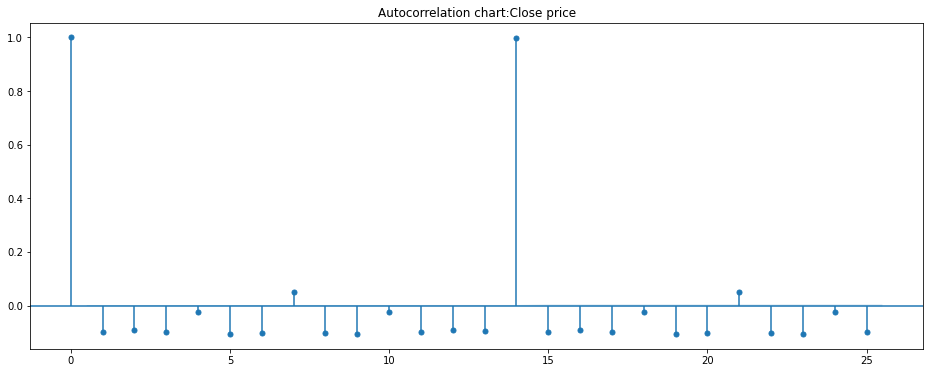

In [48]:
# Autocorrelation of Closing price of Oracle
plot_acf(df["Close"],lags=25,title="Autocorrelation chart:Close price")
plt.show()

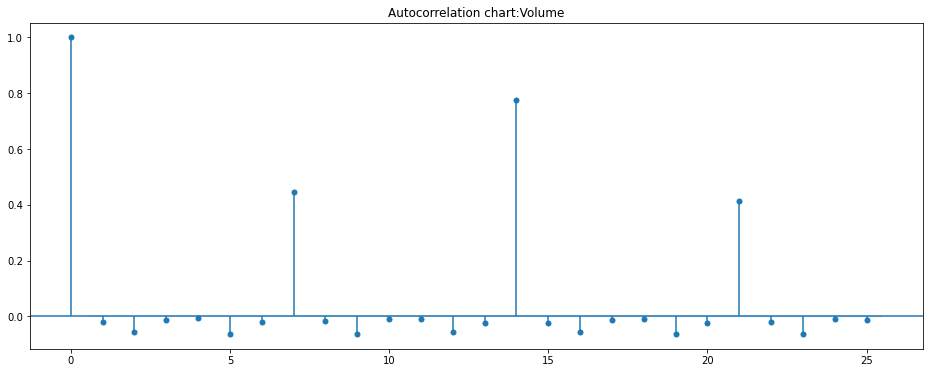

In [51]:
# Autocorrelation of Closing price of Oracle
plot_acf(df["Volume"],lags=25,title="Autocorrelation chart:Volume")
plt.show()

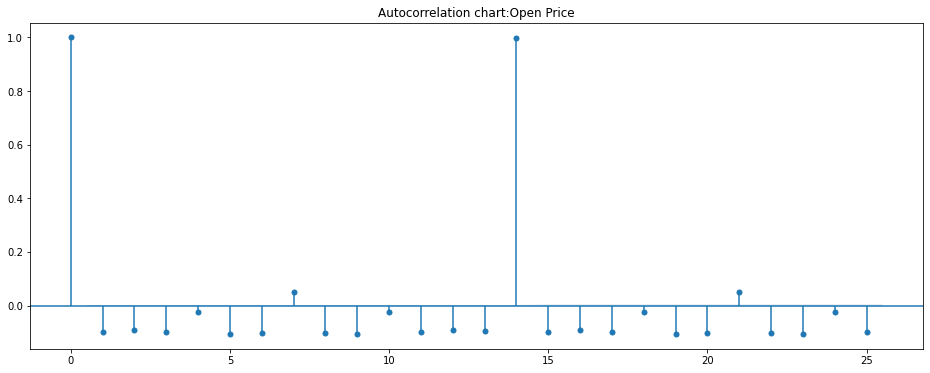

In [52]:
# Autocorrelation of Closing price of Oracle
plot_acf(df["Open"],lags=25,title="Autocorrelation chart:Open Price")
plt.show()

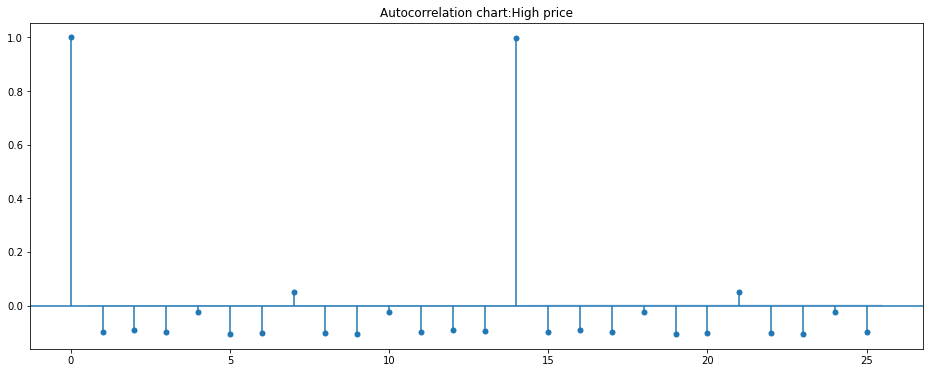

In [53]:
# Autocorrelation of Closing price of Oracle
plot_acf(df["High"],lags=25,title="Autocorrelation chart:High price")
plt.show()

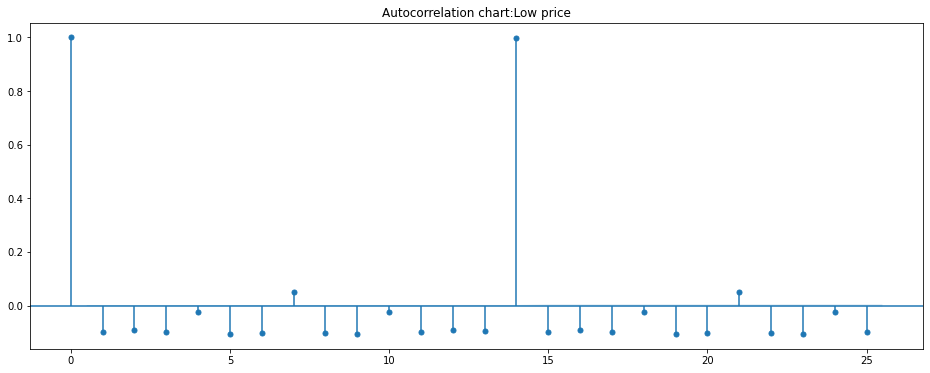

In [54]:
# Autocorrelation of Closing price of Oracle
plot_acf(df["Low"],lags=25,title="Autocorrelation chart:Low price")
plt.show()

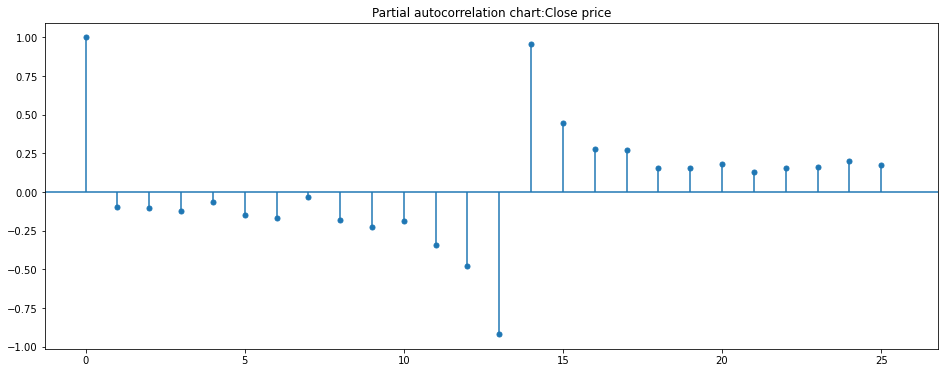

In [55]:
# Partial Autocorrelation of Closing price of Oracle
plot_pacf(df["Close"],lags=25, title="Partial autocorrelation chart:Close price")
plt.show()

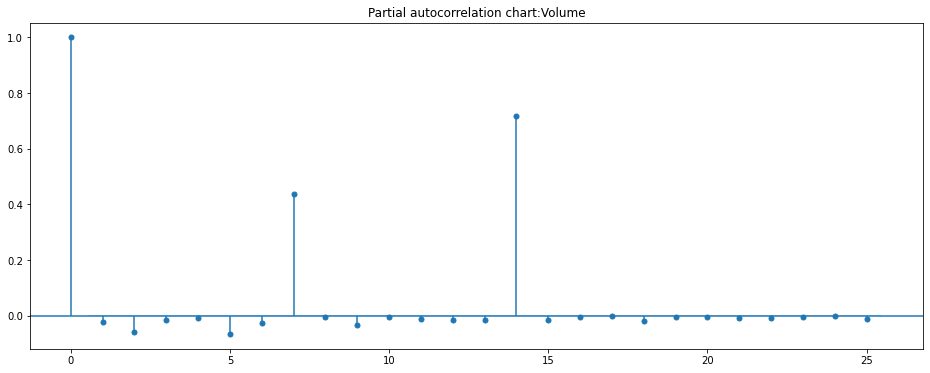

In [56]:
# Partial Autocorrelation of Closing price of Oracle
plot_pacf(df["Volume"],lags=25, title="Partial autocorrelation chart:Volume")
plt.show()

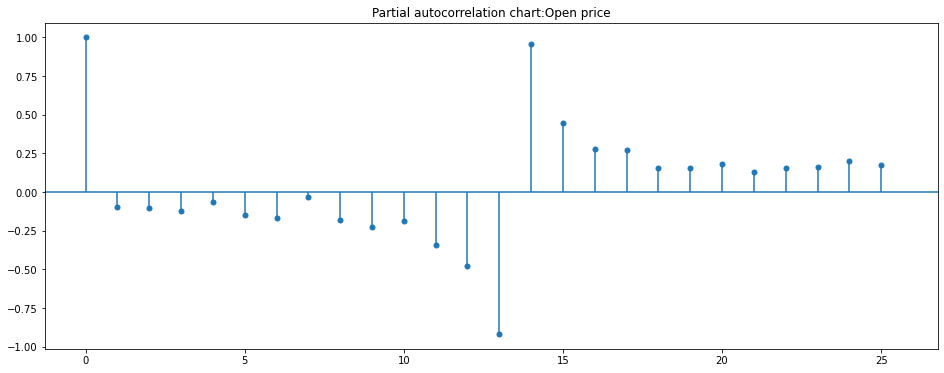

In [57]:
# Partial Autocorrelation of Closing price of Oracle
plot_pacf(df["Open"],lags=25, title="Partial autocorrelation chart:Open price")
plt.show()

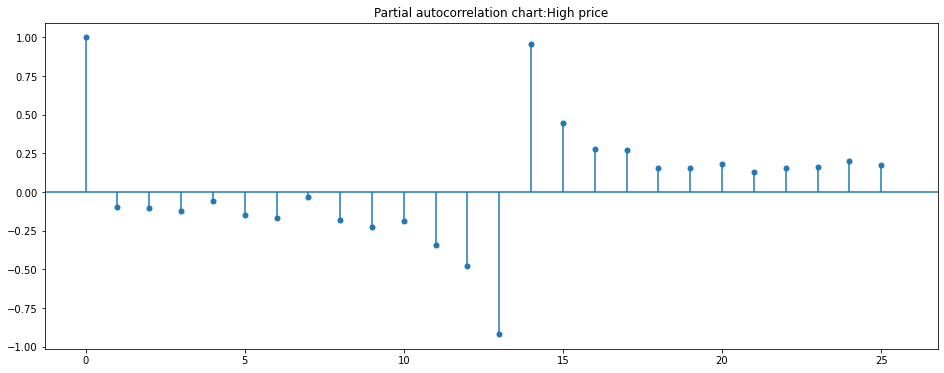

In [58]:
# Partial Autocorrelation of Closing price of Oracle
plot_pacf(df["High"],lags=25, title="Partial autocorrelation chart:High price")
plt.show()

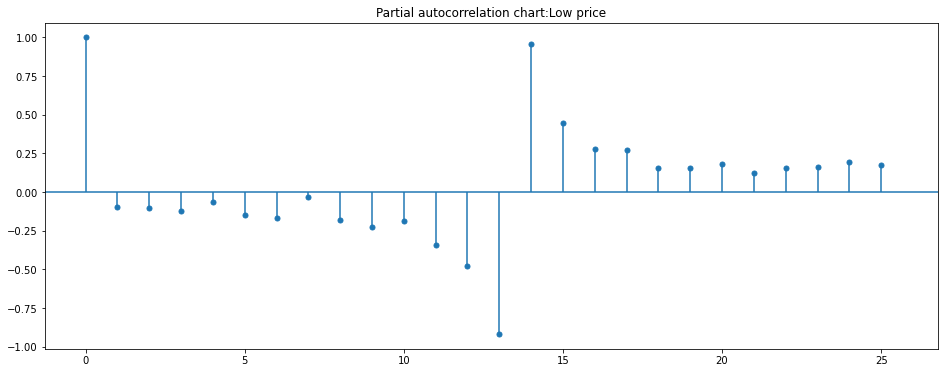

In [59]:
# Partial Autocorrelation of Closing price of Oracle
plot_pacf(df["Low"],lags=25, title="Partial autocorrelation chart:Low price")
plt.show()

## Random Walk
A random walk is a mathematical object, known as a stochastic or random process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers. 

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

# P<sub>t</sub> = P<sub>t-1</sub> + ε<sub>t</sub> 

Random walks can't be forecasted because well, noise is random.

Random Walk with Drift(drift(μ) is zero-mean)
#### P<sub>t</sub> - P<sub>t-1</sub> = μ + ε<sub>t</sub> 
<br>
Regression test for random walk 

P<sub>t</sub> = α + βP<sub>t-1</sub> + ε<sub>t</sub>
<br>
Equivalent to  P<sub>t</sub> - P<sub>t-1</sub> = α + βP<sub>t-1</sub> + ε<sub>t</sub>
<br>
Test:
H<sub>0</sub>: β = 1 (This is a random walk)
 H<sub>1</sub>: β < 1 (This is not a random walk)
<br>
Dickey-Fuller Test:
 H<sub>0</sub>: β = 0 (This is a random walk)
H<sub>1</sub>: β < 0 (This is not a random walk)


### Augmented Dickey-Fuller test
An augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. It is basically Dickey-Fuller test with more lagged changes on RHS.

In [66]:
# Augmented Dickey-Fuller test on volume of Oracle and Apple stocks 
adf = adfuller(df["Close"])
print("p-value of the dataset: {}".format(float(adf[1])))

MemoryError: Unable to allocate 671. MiB for an array with shape (88, 999879) and data type float64

# <center>MODELLING</center> 

In [28]:
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import math
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from pylab import rcParams
import warnings
warnings.filterwarnings('ignore')

### AR models
An autoregressive (AR) model is a representation of a type of random process; as such, it is used to describe certain time-varying processes in nature, economics, etc. The autoregressive model specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term); thus the model is in the form of a stochastic difference equation.

AR(1) model
R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ε<sub>t</sub>

As RHS has only one lagged value(Rt-1)this is called AR model of order 1 where μ is mean and ε is noise at time t
If ϕ = 1, it is random walk. Else if ϕ = 0, it is white noise. Else if -1 < ϕ < 1, it is stationary. If ϕ is -ve, there is men reversion. If ϕ is +ve, there is momentum.

AR(2) model
R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ε<sub>t</sub>

AR(3) model
R<sub>t</sub> = μ + ϕ<sub>1</sub>R<sub>t-1</sub> + ϕ<sub>2</sub>R<sub>t-2</sub> + ϕ<sub>3</sub>R<sub>t-3</sub> + ε<sub>t</sub>

## Simulation

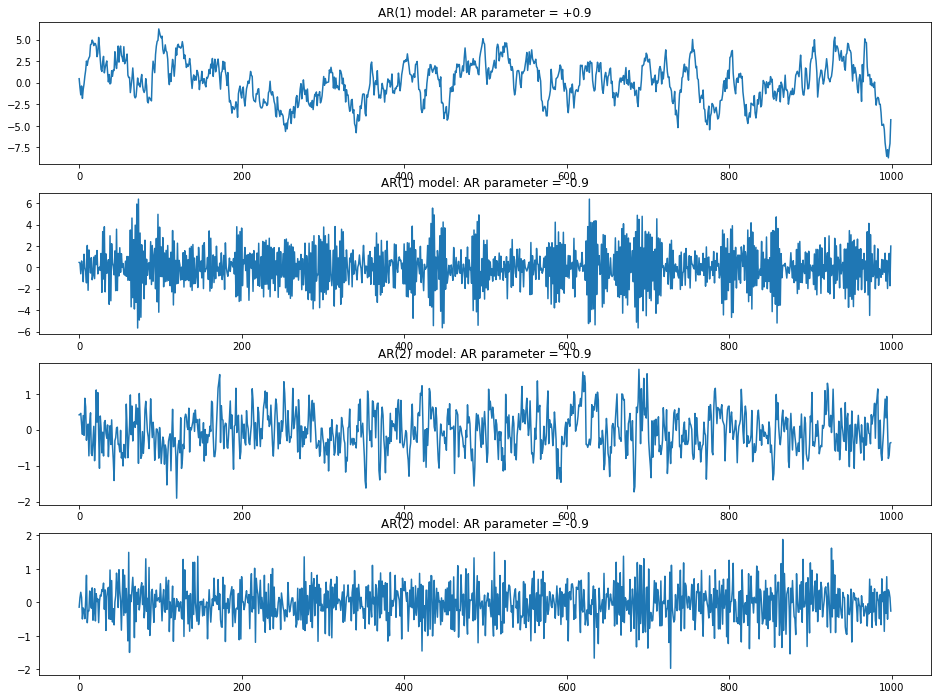

In [17]:
# AR(1) MA(1) model:AR parameter = +0.9
rcParams['figure.figsize'] = 16, 12
plt.subplot(4,1,1)
ar1 = np.array([1, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma1 = np.array([1])
AR1 = ArmaProcess(ar1, ma1)
sim1 = AR1.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = +0.9')
plt.plot(sim1)

# We will take care of MA model later
# AR(1) MA(1) AR parameter = -0.9
plt.subplot(4,1,2)
ar2 = np.array([1, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma2 = np.array([1])
AR2 = ArmaProcess(ar2, ma2)
sim2 = AR2.generate_sample(nsample=1000)
plt.title('AR(1) model: AR parameter = -0.9')
plt.plot(sim2)

# AR(2) MA(1) AR parameter = 0.9
plt.subplot(4,1,3)
ar3 = np.array([2, -0.9]) # We choose -0.9 as AR parameter is +0.9
ma3 = np.array([1])
AR3 = ArmaProcess(ar3, ma3)
sim3 = AR3.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = +0.9')
plt.plot(sim3)

# AR(2) MA(1) AR parameter = -0.9
plt.subplot(4,1,4)
ar4 = np.array([2, 0.9]) # We choose +0.9 as AR parameter is -0.9
ma4 = np.array([1])
AR4 = ArmaProcess(ar4, ma4)
sim4 = AR4.generate_sample(nsample=1000)
plt.title('AR(2) model: AR parameter = -0.9')
plt.plot(sim4)
plt.show()

In [18]:
model_AR = ARMA(sim1, order=(1,0))
result = model_AR.fit()
print(result.summary())
print("μ={} ,ϕ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1403.960
Method:                       css-mle   S.D. of innovations              0.984
Date:                Thu, 24 Nov 2022   AIC                           2813.920
Time:                        14:37:04   BIC                           2828.643
Sample:                             0   HQIC                          2819.515
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1079      0.342      0.316      0.752      -0.562       0.778
ar.L1.y        0.9099      0.013     69.341      0.000       0.884       0.936
                                    Roots           

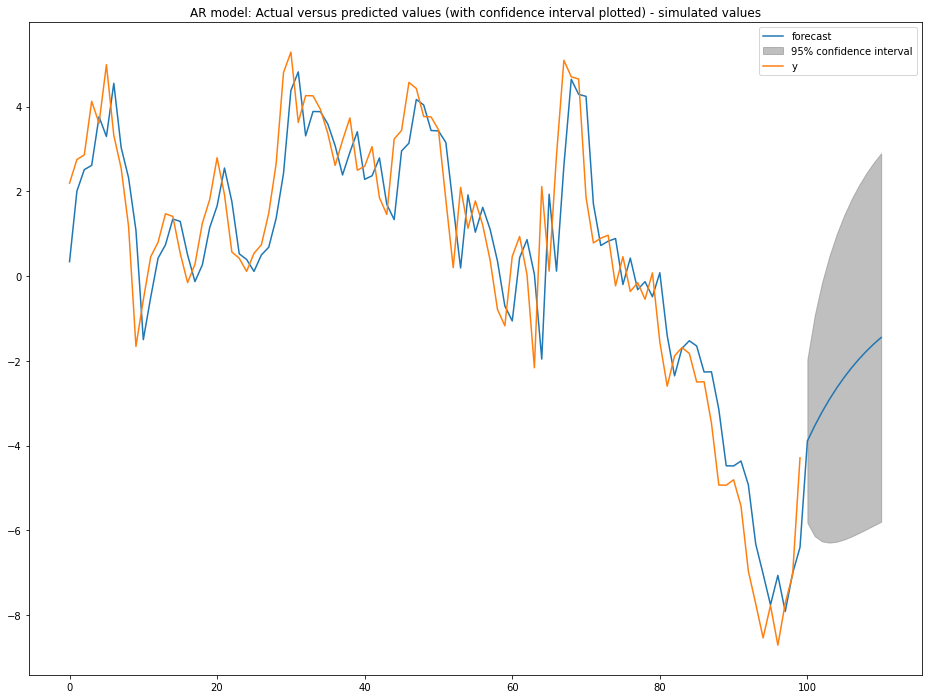

In [19]:
# Predicting simulated AR(1) model 
result.plot_predict(start=900, end=1010)
_ = plt.title('AR model: Actual versus predicted values (with confidence interval plotted) - simulated values')
plt.show()

In [20]:
rmse = math.sqrt(mean_squared_error(sim1[900:1011], result.predict(start=900,end=999)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 1.177811793529586.


### Actual Testing

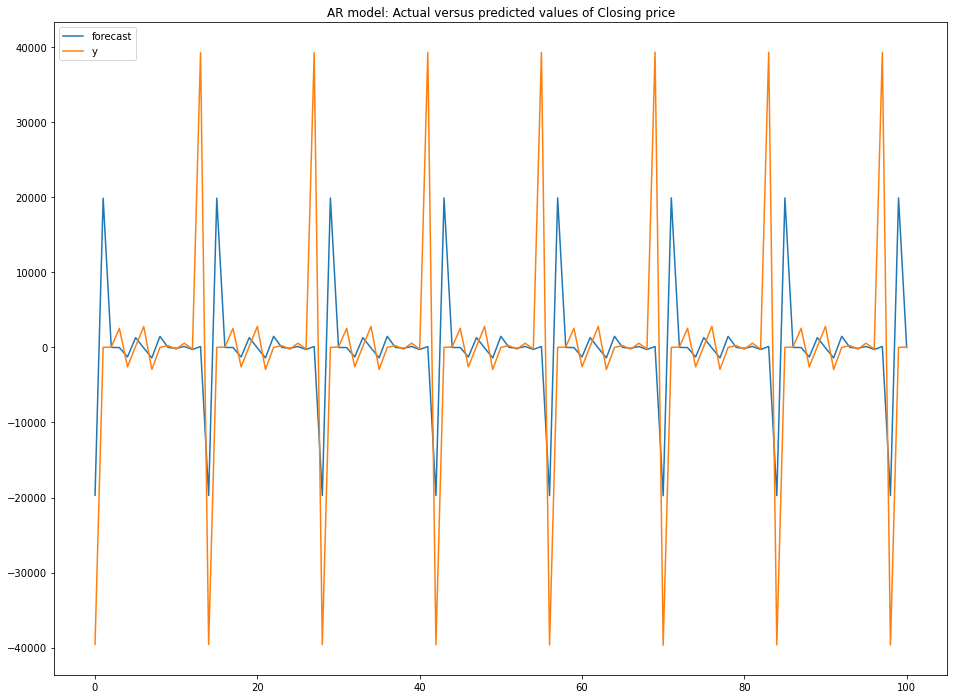

In [21]:
close_price_AR = ARMA(df["Close"].diff().iloc[1:].values, order=(1,0))
res = close_price_AR.fit()
res.plot_predict(start=1000, end=1100)
_ = plt.title('AR model: Actual versus predicted values of Closing price')
plt.show()

In [61]:
print(res.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               999999
Model:                     ARMA(1, 0)   Log Likelihood           -11051097.528
Method:                       css-mle   S.D. of innovations          15247.486
Date:                Sat, 26 Nov 2022   AIC                       22102201.057
Time:                        23:39:43   BIC                       22102236.503
Sample:                             0   HQIC                      22102210.812
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002     10.150   2.27e-05      1.000     -19.893      19.893
ar.L1.y       -0.5023      0.001   -580.862      0.000      -0.504      -0.501
                                    Roots           

In [62]:
print("μ={} ,ϕ={}".format(res.params[0],res.params[1]))

μ=0.00022995489420854162 ,ϕ=-0.5022753210897143


In [22]:
rmse = math.sqrt(mean_squared_error(df["Close"].diff().iloc[1000:1100].values, res.predict(start=1000,end=1099)))
print("The root mean squared error is {}.".format(round(rmse,5)))

The root mean squared error is 23810.51346.


###  MA models 
The moving-average (MA) model is a common approach for modeling univariate time series. The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.

#### MA(1) model
R<sub>t</sub> = μ  +  ϵ<sub>t</sub>1 + θϵ<sub>t-1</sub>

It translates to Today's returns = mean + today's noise + yesterday's noise

##### As there is only 1 lagged value in RHS, it is an MA model of order 1

#### Simulating MA(1) model

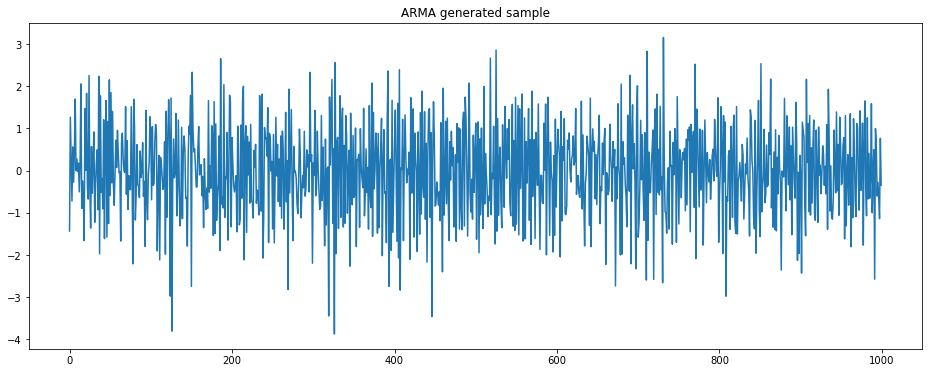

In [23]:
rcParams['figure.figsize'] = 16, 6
ar1 = np.array([1])
ma1 = np.array([1, -0.5])
MA1 = ArmaProcess(ar1, ma1)
sim1 = MA1.generate_sample(nsample=1000)
_ = plt.title('ARMA generated sample')
plt.plot(sim1)

In [24]:
model = ARMA(sim1, order=(0,1))
result = model.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1416.934
Method:                       css-mle   S.D. of innovations              0.998
Date:                Thu, 24 Nov 2022   AIC                           2839.868
Time:                        14:37:06   BIC                           2854.591
Sample:                             0   HQIC                          2845.464
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0156      0.016     -0.970      0.332      -0.047       0.016
ma.L1.y       -0.4907      0.029    -17.205      0.000      -0.547      -0.435
                                    Roots           

### Testing

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:               999999
Model:                     ARMA(0, 3)   Log Likelihood           -10719440.951
Method:                       css-mle   S.D. of innovations          10943.543
Date:                Thu, 24 Nov 2022   AIC                       21438891.903
Time:                        14:39:45   BIC                       21438950.980
Sample:                             0   HQIC                      21438908.161
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.029     -0.074      0.941      -0.059       0.055
ma.L1.y       -1.4918        nan        nan        nan         nan         nan
ma.L2.y       -0.0096        nan        nan        n

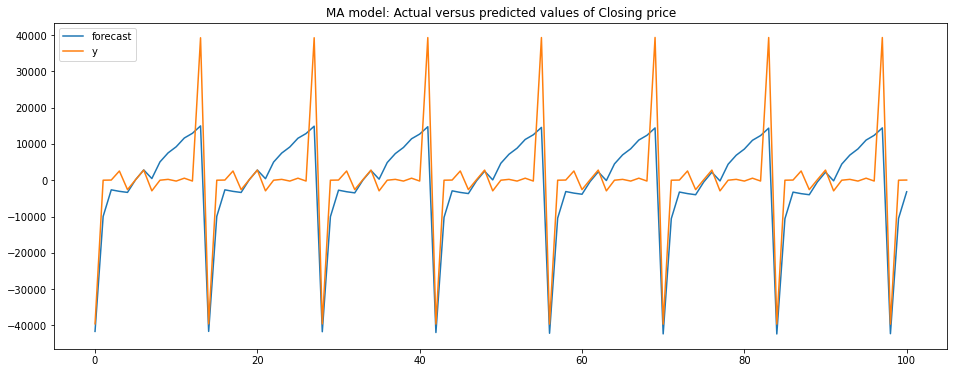

In [25]:
model_MA = ARMA(df["Close"].diff().iloc[1:].values, order=(0,3))
result = model_MA.fit()
print(result.summary())
print("μ={} ,θ={}".format(result.params[0],result.params[1]))
result.plot_predict(start=1000, end=1100)
_ = plt.title('MA model: Actual versus predicted values of Closing price')
plt.show()

In [26]:
rmse = math.sqrt(mean_squared_error(df["Close"].diff().iloc[1000:1100].values, result.predict(start=1000,end=1099)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 25515.33670373961.


### ARMA models
Autoregressive–moving-average (ARMA) models provide a parsimonious description of a (weakly) stationary stochastic process in terms of two polynomials, one for the autoregression and the second for the moving average. It's the fusion of AR and MA models.
### ARMA(1,1) model
### R<sub>t</sub> = μ + ϕR<sub>t-1</sub> + ϵ<sub>t</sub> + θϵ<sub>t-1</sub> 
Basically, Today's return = mean + Yesterday's return + noise + yesterday's noise.

model = ARMA(df["Close"].diff().iloc[1:].values, order=(3,3))
result_ARMA = model.fit()
print(result_ARMA.summary())
print("μ={}, ϕ={}, θ={}".format(result_ARMA.params[0],result_ARMA.params[1],result_ARMA.params[2]))
result_ARMA.plot_predict(start=1000, end=1100)
_ = plt.title('ARMA model: Actual versus predicted values of Closing price')
plt.show()

rmse_ARMA = math.sqrt(mean_squared_error(oracle["Close"].diff().iloc[1000:1100].values, result_ARMA.predict(start=1000,end=1099)))
print("The root mean squared error is {}.".format(rmse_ARMA))

### ARIMA models

An autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.
ARIMA model is of the form: ARIMA(p,d,q): p is AR parameter, d is differential parameter, q is MA parameter

#### ARIMA(1,0,0)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub>**
#### ARIMA(1,0,1)
**y<sub>t</sub> = a<sub>1</sub>y<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>**
#### ARIMA(1,1,1)
**Δy<sub>t</sub> = a<sub>1</sub>Δy<sub>t-1</sub> + ϵ<sub>t</sub> + b<sub>1</sub>ϵ<sub>t-1</sub>** where **Δy<sub>t</sub> = y<sub>t</sub> - y<sub>t-1</sub>**

In [30]:
rcParams['figure.figsize'] = 16, 6
model_ARIMA = ARIMA(df["Close"].diff().iloc[1:].values, order=(2,1,0))
result_ARIMA = model_ARIMA.fit()
print(result_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               999999
Model:                 ARIMA(2, 1, 0)   Log Likelihood           -11320082.538
Date:                Thu, 24 Nov 2022   AIC                       22640171.077
Time:                        15:08:15   BIC                       22640206.523
Sample:                             0   HQIC                      22640180.832
                             - 999999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9888      0.001  -1794.574      0.000      -0.990      -0.988
ar.L2         -0.4778      0.001   -454.976      0.000      -0.480      -0.476
sigma2      3.981e+08   6.33e-13   6.29e+20      0.0

In [63]:
print("μ={}, ϕ={}, θ={}".format(result_ARIMA.params[0],result_ARIMA.params[1],result_ARIMA.params[2]))

μ=-0.9888350971340516, ϕ=-0.4777696060272587, θ=398148269.4412765


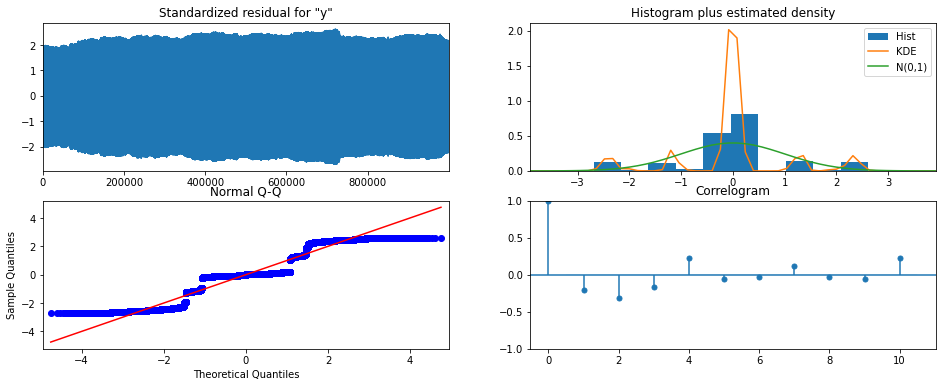

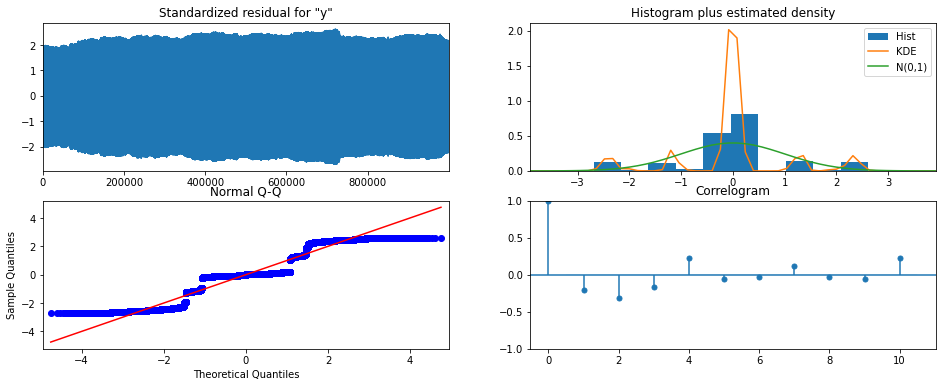

In [44]:
result_ARIMA.plot_diagnostics()

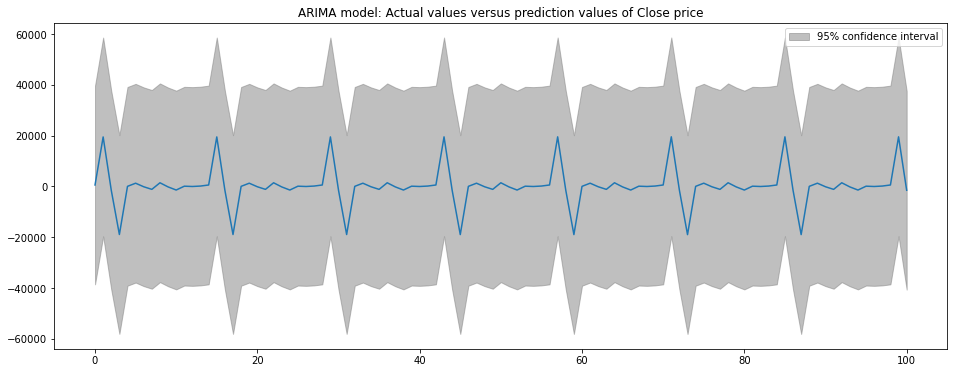

In [32]:
plot_predict(result_ARIMA,start=1000, end=1100)
_ = plt.title('ARIMA model: Actual values versus prediction values of Close price')
#plt.show()

In [33]:
rmse_ARIMA = math.sqrt(mean_squared_error(data["Close"].diff().iloc[1000:1100].values, result_ARIMA.predict(start=1000,end=1099)))
print("The root mean squared error is {}.".format(rmse_ARIMA))

The root mean squared error is 10153.028270895675.


### SARIMAX models
SARIMA models are useful for modeling seasonal time series, in which the mean and other statistics for a given season are not stationary across the years. The SARIMA model defined constitutes a straightforward extension of the nonseasonal autoregressive-moving average (ARMA) and autoregressive integrated moving average (ARIMA) models presented

In [35]:
train_sample = df["Close"].diff().iloc[1:].values
model_SAR = sm.tsa.SARIMAX(train_sample,order=(4,0,4),trend='c', enforce_invertibility=False, enforce_stationarity=False)
result_SAR = model_SAR.fit(maxiter=1000, disp=False)
print(result_SAR.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               999999
Model:               SARIMAX(4, 0, 4)   Log Likelihood           -10725898.353
Date:                Thu, 24 Nov 2022   AIC                       21451816.707
Time:                        18:38:08   BIC                       21451934.862
Sample:                             0   HQIC                      21451849.222
                             - 999999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3466      0.183      1.892      0.058      -0.012       0.706
ar.L1         -1.2942      0.022    -57.868      0.000      -1.338      -1.250
ar.L2         -1.3754      0.020    -69.927      0.0

In [64]:
print("μ={}, ϕ={}, θ={}".format(result_SAR.params[0],result_SAR.params[1],result_SAR.params[2]))

μ=0.34663443889031625, ϕ=-1.2941638838472858, θ=-1.3754101774339018


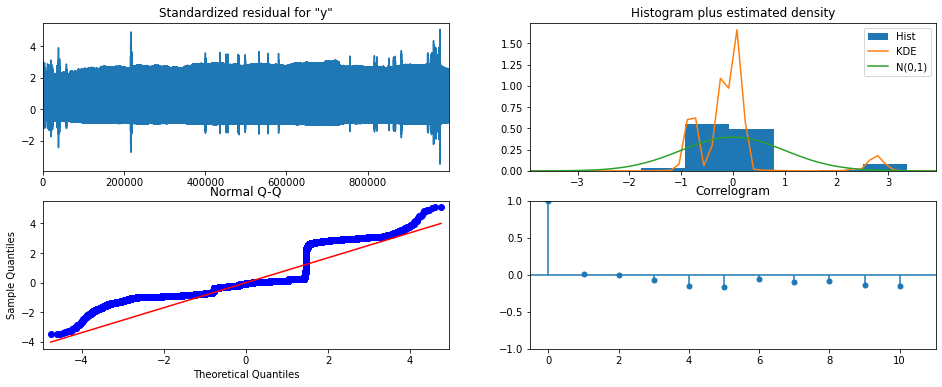

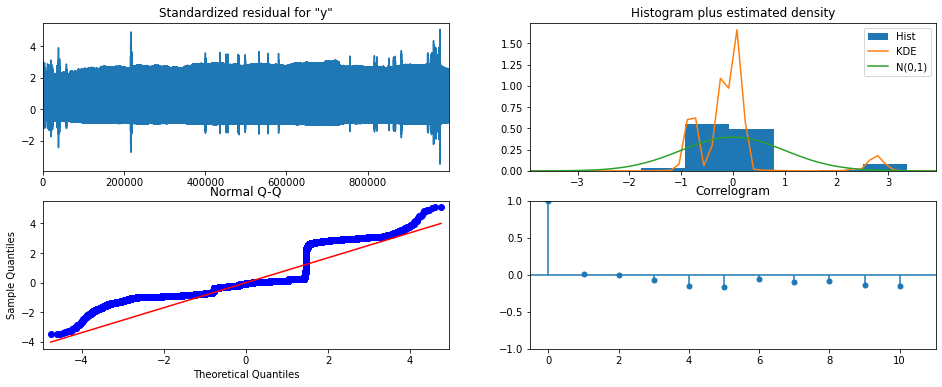

In [60]:
predicted_result_SAR = result_SAR.predict(start=1000, end=1100)
result_SAR.plot_diagnostics()

In [41]:
# calculating error
rmse = math.sqrt(mean_squared_error(train_sample[999:1100], predicted_result_SAR))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 25563.731163322474.


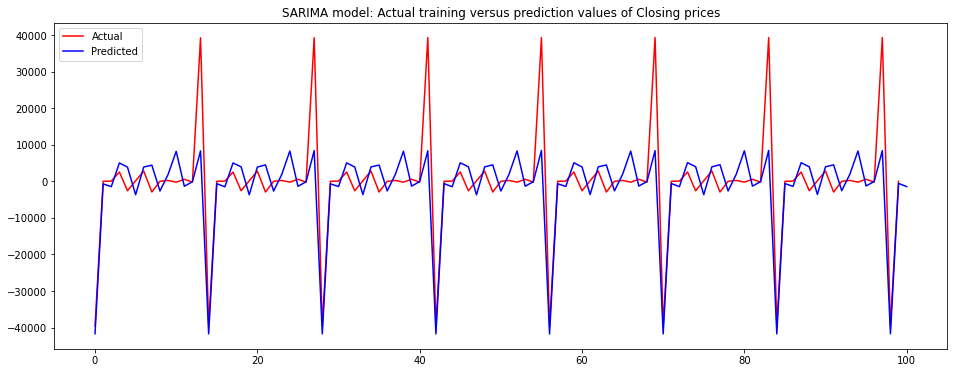

In [43]:
plt.plot(train_sample[1000:1100],color='red')
plt.plot(predicted_result_SAR,color='blue')
plt.legend(['Actual','Predicted'])
plt.title('SARIMA model: Actual training versus prediction values of Closing prices')
plt.show()